### This notebook includes all code used to run TabPFN model on the dataset used in this thesis.

In [ ]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

import joblib
from tabpfn import TabPFNRegressor

In [ ]:
# Paths

PROJECT_DIR = "/content"

EXPORT_DIR = os.path.join(PROJECT_DIR)
RESULTS_DIR = os.path.join(PROJECT_DIR, "results", "tabpfn")
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)


In [ ]:
# Metrics helper (R², RMSE, MAE)

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "R2": float(r2),
        "RMSE": float(rmse),
        "MAE": float(mae)
    }


In [ ]:
# Function for TabPFN

def run_tabpfn(tag, train_csv, test_csv, save_as_default_predictions=False):
    train_path = os.path.join(EXPORT_DIR, train_csv)
    test_path  = os.path.join(EXPORT_DIR, test_csv)

    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    assert "bmi" in train_df.columns, f"{tag}: train csv missing 'bmi'"
    assert "bmi" in test_df.columns,  f"{tag}: test csv missing 'bmi'"

    y_train = train_df["bmi"].to_numpy(dtype=float)
    X_train = train_df.drop(columns=["bmi"]).to_numpy(dtype=float)

    y_test = test_df["bmi"].to_numpy(dtype=float)
    X_test = test_df.drop(columns=["bmi"]).to_numpy(dtype=float)

    feature_names = list(train_df.drop(columns=["bmi"]).columns)

    model = TabPFNRegressor(device="auto")
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    metrics = compute_metrics(y_test, preds)

    print(f"{tag} metrics:", metrics)

    # Save model
    joblib.dump(model, os.path.join(RESULTS_DIR, f"model_{tag}.pkl"))

    # Save predictions
    pred_out = pd.DataFrame({"y_true": y_test, "y_pred": preds})
    pred_out.to_csv(os.path.join(RESULTS_DIR, f"predictions_test_{tag}.csv"), index=False)

    # Optionally: write the default name used by R model_comparison.R
    if save_as_default_predictions:
        pred_out.to_csv(os.path.join(RESULTS_DIR, "predictions_test.csv"), index=False)

    # Save metrics
    with open(os.path.join(RESULTS_DIR, f"metrics_test_{tag}.json"), "w") as f:
        json.dump({k: metrics[k] for k in ["R2", "RMSE", "MAE"]}, f, indent=2)

    # Save feature names
    pd.DataFrame({"feature": feature_names}).to_csv(
        os.path.join(RESULTS_DIR, f"feature_names_{tag}.csv"),
        index=False
    )

    return {
        "tag": tag,
        "model": model,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "feature_names": feature_names,
        "metrics": metrics
    }


In [ ]:
# MAIN dataset for scaling + SHAP:
res_micro = run_tabpfn(
    tag="microbiome",
    train_csv="train_microbiome.csv",
    test_csv="test_microbiome.csv",
    save_as_default_predictions=True   # so R model_comparison picks microbiome TabPFN
)

# Metrics-only comparisons (no SHAP, no scaling):
res_full = run_tabpfn("full", "train_full.csv", "test_full.csv")
res_meta = run_tabpfn("metadata", "train_metadata.csv", "test_metadata.csv")

# Save one summary table
summary_df = pd.DataFrame([
    {"dataset": "microbiome", "model": "TabPFN", **res_micro["metrics"]},
    {"dataset": "full",       "model": "TabPFN", **res_full["metrics"]},
    {"dataset": "metadata",   "model": "TabPFN", **res_meta["metrics"]},
])
summary_df.to_csv(os.path.join(RESULTS_DIR, "microbiome_vs_metadata_metrics_tabpfn.csv"), index=False)
summary_df

tabpfn-v2.5-regressor-v2.5_default.ckpt:   0%|          | 0.00/40.8M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

microbiome metrics: {'R2': 0.22780290930317726, 'RMSE': 4.752491689452996, 'MAE': 3.4276744300493314}
full metrics: {'R2': 0.3095818316901833, 'RMSE': 4.49379639197557, 'MAE': 3.254359121553052}
metadata metrics: {'R2': 0.04265368025810379, 'RMSE': 5.291658653835032, 'MAE': 3.6977271124103455}


,dataset,model,R2,RMSE,MAE
0,microbiome,TabPFN,0.227803,4.752492,3.427674
1,full,TabPFN,0.309582,4.493796,3.254359
2,metadata,TabPFN,0.042654,5.291659,3.697727


In [ ]:
# Scaling experiment

DATASET_SIZES = [50, 100, 500, 1000, 2000, 5000, res_micro["X_train"].shape[0]]

scaling_rows = []
for n in DATASET_SIZES:
    n = int(min(n, res_micro["X_train"].shape[0]))

    m = TabPFNRegressor(device="auto")
    m.fit(res_micro["X_train"][:n], res_micro["y_train"][:n])

    preds = m.predict(res_micro["X_test"])
    met = compute_metrics(res_micro["y_test"], preds)

    scaling_rows.append({
        "n": n,
        "model": "TabPFN",
        "dataset": "microbiome",
        "R2": met["R2"],
        "RMSE": met["RMSE"],
        "MAE": met["MAE"]
    })

scaling_df = pd.DataFrame(scaling_rows)
scaling_df.to_csv(os.path.join(RESULTS_DIR, "scaling_results_microbiome.csv"), index=False)

print("Saved scaling results:", os.path.join(RESULTS_DIR, "scaling_results_microbiome.csv"))


Saved scaling results: /content/results/tabpfn/scaling_results_microbiome.csv


PermutationExplainer explainer: 51it [2:31:25, 181.72s/it]


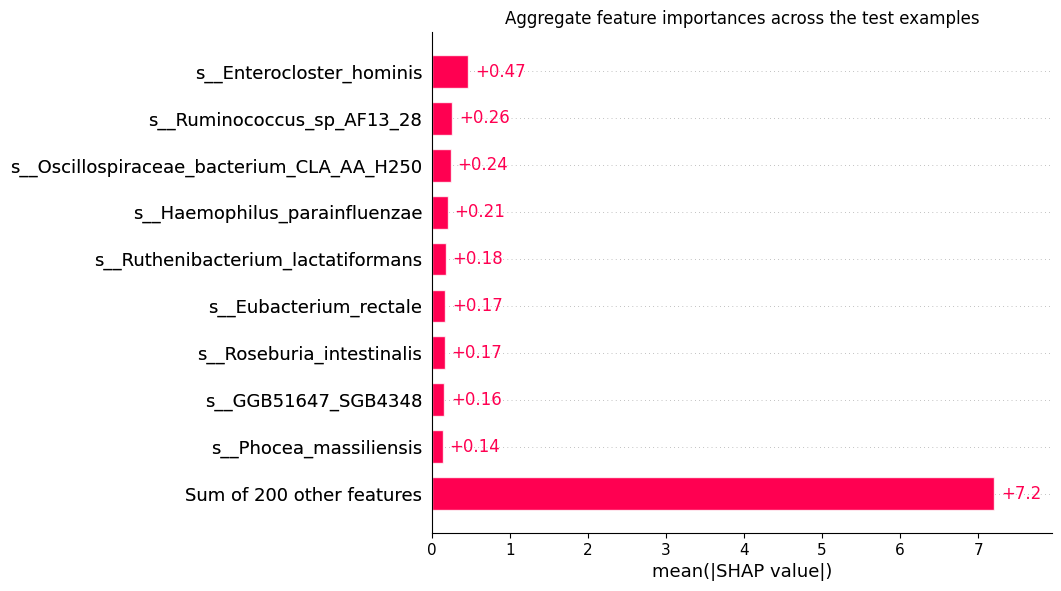

/usr/local/lib/python3.12/dist-packages/tabpfn_extensions/interpretability/shap.py:137: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


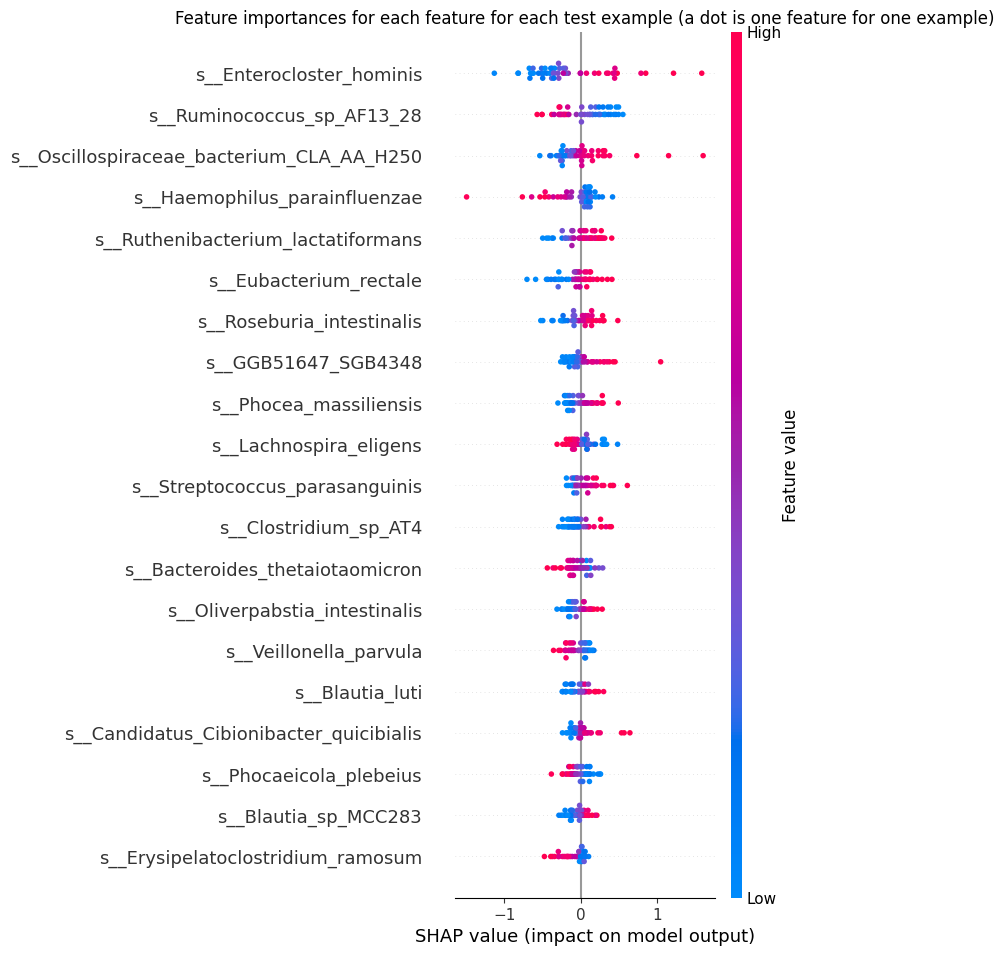

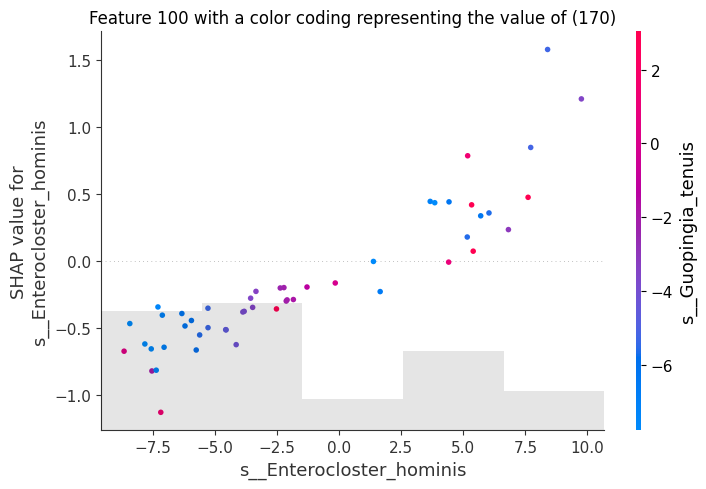

SHAP saved.


In [10]:
# SHAP

from tabpfn_extensions import interpretability
import matplotlib.pyplot as plt

n_samples = 50
shap_values = interpretability.shap.get_shap_values(
    estimator=res_micro["model"],
    test_x=res_micro["X_test"][:n_samples],
    attribute_names=res_micro["feature_names"],
    algorithm="permutation",
)

fig = interpretability.shap.plot_shap(shap_values)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "shap_summary_microbiome.png"), dpi=300)
plt.show()

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": res_micro["feature_names"],
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

shap_df.to_csv(os.path.join(RESULTS_DIR, "shap_importance_microbiome.csv"), index=False)
shap_df.head(20).to_csv(os.path.join(RESULTS_DIR, "shap_top20_microbiome.csv"), index=False)

joblib.dump(shap_df, os.path.join(RESULTS_DIR, "shap_full_microbiome.pkl"))

print("SHAP saved.")